In [19]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import train_test_split. Crossval score. Gridsearch CV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

# Import metrics
from sklearn import metrics

# Import Pipeline
from sklearn.pipeline import Pipeline

# Import models

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier


# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import make_classification

from sklearn.metrics import classification_report, accuracy_score

from sklearn.svm import LinearSVC, SVC

In [20]:
df = pd.read_csv('../data/clean_data_state_response.csv')
df_text = pd.read_csv('../data/numeric_text_combined_state_response.csv')

In [21]:
df.head()

,protestnumber,protesterviolence,participants,notes,accomodation,arrests,beatings,crowd dispersal,ignore,killings,...,year_2017,year_2018,year_2019,region_Asia,region_Central America,region_Europe,region_MENA,region_North America,region_Oceania,region_South America
0,1,0.0,3000,Canada s railway passenger system was finally...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,2,0.0,1000,protestors were only identified as young peop...,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,3,0.0,500,"THE Queen, after calling on Canadians to rema...",0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,4,1.0,300,Canada s federal government has agreed to acq...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,1.0,950,Protests were directed against the state due t...,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [22]:
df.shape

(14474, 222)

In [23]:
df.columns[:30]

Index(['protestnumber', 'protesterviolence', 'participants', 'notes',
       'accomodation', 'arrests', 'beatings', 'crowd dispersal', 'ignore',
       'killings', 'shootings', 'stateresponse', 'stateresponse_violence',
       'labor wage dispute', 'land farm issue', 'police brutality',
       'political behavior, process', 'price increases, tax policy',
       'removal of politician', 'social restrictions', 'duration',
       'country_Albania', 'country_Algeria', 'country_Angola',
       'country_Argentina', 'country_Armenia', 'country_Austria',
       'country_Azerbaijan', 'country_Bahrain', 'country_Bangladesh'],
      dtype='object')

# Model Prep - NO TEXT

Note: We're going to try two models.  One predicting 'protesterviolence' for that we'll only need to drop the 'stateresponse' variable (which was our original DV).

The 2nd model we'll try to predict 'stateresponse_violence' and for that we'll need to drop the individual state responses.  We'll call those 'responses' below

In [24]:
responses = ['accomodation', 'arrests', 'beatings', 'crowd dispersal', 'ignore', 'killings', 'shootings']

In [25]:
df.drop(columns=['notes', 'stateresponse'], inplace=True)

In [26]:
# Step 1: Split into training & testing sets
X = df.drop(columns='protesterviolence')
y = df['protesterviolence']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

In [27]:
X.shape, y.shape

((14474, 219), (14474,))

In [28]:
# Get the baseline model performance
y_test.value_counts(normalize = True)

0.0    0.736944
1.0    0.263056
Name: protesterviolence, dtype: float64

# Ada Boost

In [29]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [.9, .1],
    'base_estimator__max_depth': [1, 2, 3]
}

gs = GridSearchCV(ada, param_grid=ada_params, cv=4, verbose=2, n_jobs=-1)
gs.fit(X_train, y_train)
print('GridSearchCV best score: ', gs.best_score_)
gs.best_params_

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:   15.1s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   15.8s finished


GridSearchCV best score:  0.8184242006268571


{'base_estimator__max_depth': 3, 'learning_rate': 0.9, 'n_estimators': 50}

In [30]:
print('Train score: ', gs.score(X_train, y_train))
print('Test score: ', gs.score(X_test, y_test))

Train score:  0.8557346844771995
Test score:  0.8109975131251727


In [32]:
# Best way of interpreting the results of a tree-based ensemble estimator - weighted gini score for each tree averaged
gs.best_estimator_.feature_importances_

array([8.22838528e-02, 8.27427635e-02, 1.76830649e-02, 1.92429673e-02,
       6.11823107e-03, 4.85836029e-02, 3.39886309e-02, 1.24169433e-02,
       5.96091196e-03, 3.21440946e-02, 2.04108019e-02, 4.04979270e-03,
       1.39596626e-02, 1.75810622e-02, 1.50231542e-02, 9.71410876e-03,
       5.33450750e-03, 4.36315115e-02, 2.57688906e-03, 0.00000000e+00,
       3.33448255e-03, 2.44698158e-03, 2.32069360e-03, 0.00000000e+00,
       2.49080959e-03, 2.02597369e-03, 0.00000000e+00, 4.46467379e-03,
       2.83069971e-03, 2.17907095e-03, 2.95145894e-03, 3.86664949e-03,
       3.34668443e-03, 2.31712759e-03, 1.91496663e-03, 0.00000000e+00,
       6.91975990e-03, 1.65193834e-02, 2.02233695e-03, 0.00000000e+00,
       2.22928608e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.80347666e-03, 2.30474717e-03, 3.09980191e-03,
       4.09197884e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.96559367e-03, 3.80092946e-03, 0.00000000e+00, 0.00000000e+00,
      

In [33]:
# Get the most important features from adaboost
imp_list = gs.best_estimator_.feature_importances_

In [34]:
# Get the column names from the training features
col_names = X.columns

In [35]:
# Get the importance scores
imp = pd.DataFrame(imp_list, index=col_names, columns=['feat imp'])

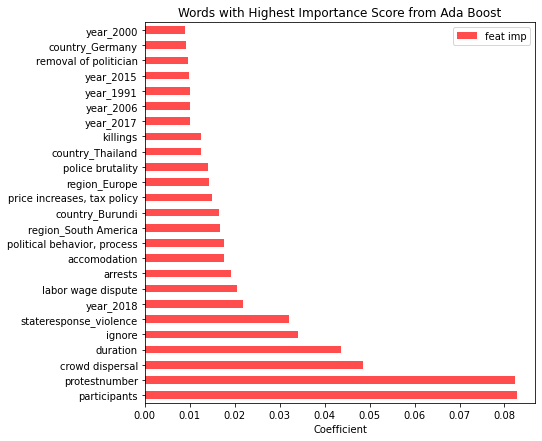

In [36]:
# Plot the importance scores for the most important features
imp.sort_values('feat imp', ascending = False).head(25).plot(kind= 'barh', color = 'red', alpha = 0.7, figsize = (7,7))
#plt.yticks(rotation = 70)
plt.xlabel('Coefficient')
plt.title('Words with Highest Importance Score from Ada Boost')
plt.savefig("../figs/importance_scores.png")

### Model does pretty well without much fuss and these results are pretty interesting!  Some of our state responses showed up!!  It would be interesting to attach some correlation coefficients to these to determine direction.

### Now let's try to predict state response

In [37]:
df.drop(columns=responses, inplace=True)

In [38]:
# Step 1: Split into training & testing sets
X = df.drop(columns='stateresponse_violence')
y = df['stateresponse_violence']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

In [39]:
X.shape, y.shape

((14474, 212), (14474,))

In [40]:
# Get the baseline model performance
y_test.value_counts(normalize = True)

0    0.7748
1    0.2252
Name: stateresponse_violence, dtype: float64

# Ada Boost

In [41]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [.9, .1],
    'base_estimator__max_depth': [1, 2, 3]
}

gs = GridSearchCV(ada, param_grid=ada_params, cv=4, verbose=2, n_jobs=-1)
gs.fit(X_train, y_train)
print('GridSearchCV best score: ', gs.best_score_)
gs.best_params_

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:   16.2s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   16.8s finished


GridSearchCV best score:  0.805619236618579


{'base_estimator__max_depth': 2, 'learning_rate': 0.9, 'n_estimators': 100}

In [42]:
print('Train score: ', gs.score(X_train, y_train))
print('Test score: ', gs.score(X_test, y_test))

Train score:  0.8291110087517273
Test score:  0.7969052224371374


In [43]:
# Best way of interpreting the results of a tree-based ensemble estimator - weighted gini score for each tree averaged
gs.best_estimator_.feature_importances_

array([0.1182795 , 0.07108594, 0.11006349, 0.0104561 , 0.00107151,
       0.01750509, 0.0140795 , 0.01622273, 0.02881447, 0.00061996,
       0.03328861, 0.00382883, 0.00311875, 0.00303395, 0.        ,
       0.00759983, 0.        , 0.012901  , 0.        , 0.00406406,
       0.00936312, 0.        , 0.00211729, 0.        , 0.00207405,
       0.0027812 , 0.00359471, 0.        , 0.00274299, 0.        ,
       0.        , 0.0020852 , 0.00393387, 0.        , 0.00209701,
       0.        , 0.00384279, 0.00661244, 0.00259027, 0.        ,
       0.        , 0.        , 0.00461975, 0.        , 0.00491989,
       0.00464722, 0.00272267, 0.00508011, 0.00208086, 0.0047264 ,
       0.00373376, 0.        , 0.00196656, 0.00337223, 0.00300075,
       0.00232931, 0.00232263, 0.00249774, 0.00346485, 0.        ,
       0.00433324, 0.00373249, 0.00115753, 0.0039908 , 0.0073273 ,
       0.00499968, 0.00240073, 0.00415182, 0.00216452, 0.00332389,
       0.00459316, 0.        , 0.        , 0.00130446, 0.00404

In [44]:
# Get the most important features from adaboost
imp_list = gs.best_estimator_.feature_importances_

In [45]:
# Get the column names from the training features
col_names = X.columns

In [46]:
# Get the importance scores
imp = pd.DataFrame(imp_list, index=col_names, columns=['feat imp'])

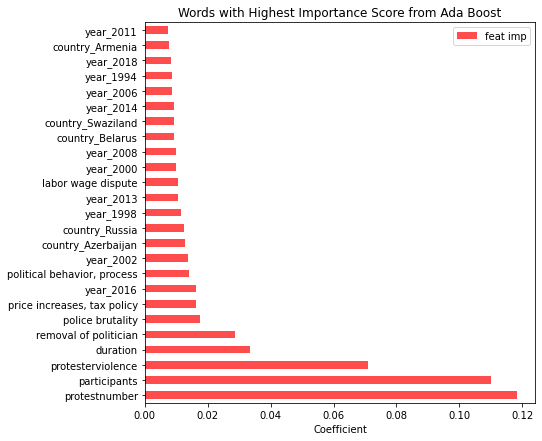

In [47]:
# Plot the importance scores for the most important features
imp.sort_values('feat imp', ascending = False).head(25).plot(kind= 'barh', color = 'red', alpha = 0.7, figsize = (7,7))
#plt.yticks(rotation = 70)
plt.xlabel('Coefficient')
plt.title('Words with Highest Importance Score from Ada Boost')
plt.savefig("../figs/importance_scores.png")

### This model performs comparably well.    There are more years and countries at the top here.  Maybe less actionable information overall?